## Goal of the notebook

* **Knowing how the ant perceives the trail.**
* **Getting the speed, distance from trail, body axis angle, antennal overlap with the trail of the ant from the nearest point of the trail at any moment.**

I am researching how ants perceive pheromone trails and how they follow the trail. For that, I have collected data on the trajectory, and videos of ants following hand-drawn trails. I also have the x and y coordinates of the points that constitute the trail, the x and y coordinates of various body points of the ants using DeepLabCut while following the trail, and the curvature of the antennae which is a proxy of whether the ant is sampling the trail or ground. More curvature of the antenna means more probability of the ant sampling the ground.

***
* First, let's import the necessary modules.

In [11]:
import numpy as np
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#import skimage, PIL
#from shapely.geometry import Polygon, Point
from scipy.spatial.distance import cdist
from matplotlib.patches import Rectangle
from shapely.geometry import LineString
import cv2
import os
import math
from scipy.stats import mode
from IPython.display import display, HTML

degree_sign = chr(176)

sns.set_theme(style="darkgrid")
pd.options.display.max_colwidth = 120
%matplotlib inline

In [45]:
# OPTIONAL
#To get the indentation of the code correcty
#!pip install autopep8
'''
%load_ext autoreload
%autoreload 2
%load_ext lab_black
%config IPCompleter.use_jedi=False
%config Completer.use_jedi=False
'''

'\n%load_ext autoreload\n%autoreload 2\n%load_ext lab_black\n%config IPCompleter.use_jedi=False\n%config Completer.use_jedi=False\n'

***
## STEP 1: Load the data
* First, import the data on the trajectory/position of the ant in the arena, it's DeepLabCut body points, the trail data, and the antennal sampling data.

* Provide the correct path to the folder containing the files.
* Inside the final folder (in this case, the date folder), data should be stored in appropriate folders with proper names - position_data, DLC_bodypoints_data, trail_diagram, antennal_smapling_index_data.

In [107]:
path_file_folder = "/Users/souvikmandal/Documents/04_trail_tracking_ants/BU_trail/data_all/20220714"
file_name_template = "antmovie220714150105_ant09_trail2_144633"


#Don't change anything below this in this cell.

'''LOAD TRAJECTORY/ POSITION DATA'''
# Use glob to find files that match the pattern
matching_position_files = glob.glob(os.path.join(path_file_folder, "position_data", file_name_template +"*" + ".csv"))

# matching_files will be a list of all files that match the pattern. 
# I'm assuming you want the first match (if there are multiple).
if matching_position_files:
    path_ant_trajectory = matching_position_files[0]
    df_trajectory = pd.read_csv(path_ant_trajectory, index_col=0)
    message1 = """
    Ant trajectory data loaded as 
    <span style="background-color: #f5f5f5; border: 1px solid #ccc; padding: 2px 4px; font-family: monospace;">df_trajectory</span> 
    Pandas file.
    """
    display(HTML(message1))

else:
    path_ant_trajectory = None
    print("No matching ant_trajectory file found!")
    

'''LOAD DLC DATA'''
folder_dlc = os.path.join(path_file_folder, "DLC_bodypoints_data")
file_name_pattern_dlc = f"{file_name_template}*"

# Use glob to find files that match the pattern
matching_files_dlc = glob.glob(os.path.join(folder_dlc, file_name_pattern_dlc + ".h5"))

# Filter out files with "filtered" in their name
non_filtered_files = [file for file in matching_files_dlc if "filtered" not in file]

# We'll assume you want the first match (if there are multiple).
if non_filtered_files:
    path_dlc_data = non_filtered_files[0]
    df_dlc = pd.read_hdf(path_dlc_data)
    message2 = """
    DLC data loaded as 
    <span style="background-color: #f5f5f5; border: 1px solid #ccc; padding: 2px 4px; font-family: monospace;">df_dlc</span> 
    Pandas file.
    """
    display(HTML(message2))
else:
    path_dlc_data = None
    print("No matching non-filtered .h5 file found!")
    
    
'''LOAD TRAIL DATA'''
# Extract the last 14 characters from the file_name_pattern
trail_suffix = file_name_template[-14:]

# Define the folder and search for the CSV file with the trail_suffix
folder_trail_diagram = os.path.join(path_file_folder, "trail_diagram")
matching_files_trail = glob.glob(os.path.join(folder_trail_diagram, f"*{trail_suffix}.csv"))

if matching_files_trail:
    path_trail_data = matching_files_trail[0]
    pdf_trail = pd.read_csv(path_trail_data)
    trail_x_loc = pdf_trail['x_loc'].values
    trail_y_loc = pdf_trail['y_loc'].values
    
    # Compute the pairwise distances between consecutive points
    distances = np.sqrt(np.diff(trail_x_loc)**2 + np.diff(trail_y_loc)**2)
    # Identify the index of the point after the largest distance
    problematic_index = np.argmax(distances) + 1
    # Remove the problematic point
    trail_x_loc = np.delete(trail_x_loc, problematic_index)
    trail_y_loc = np.delete(trail_y_loc, problematic_index)
    # Create df_trail
    df_trail = np.column_stack((trail_x_loc, trail_y_loc))
    message3 = """
    Trail data is loaded as 
    <span style="background-color: #f5f5f5; border: 1px solid #ccc; padding: 2px 4px; font-family: monospace;">df_trail</span> 
    NumPy file.
    """
    display(HTML(message3))    
else:
    path_trail_data = None
    print(f"No matching trail CSV file found with suffix {trail_suffix}!")

    
'''LOAD ANTENNAL SAMPLING DATA'''
# Define the folder and search for the CSV file with the file_name_pattern
folder_antennal_sampling = os.path.join(path_file_folder, "antennal_smapling_index_data")
matching_files_antennal = glob.glob(os.path.join(folder_antennal_sampling, f"{file_name_template}*.csv"))

if matching_files_antennal:
    path_antennal_data = matching_files_antennal[0]
    df_antennal_sample = pd.read_csv(path_antennal_data)
    message4 = """
    Antennal sampling data is loaded as 
    <span style="background-color: #f5f5f5; border: 1px solid #ccc; padding: 2px 4px; font-family: monospace;">df_antennal_sample</span> 
    Pandas file.
    """
    display(HTML(message4))
else:
    path_antennal_data = None
    print(f"No matching CSV file found with pattern {file_name_pattern}!")


print(
    "The loaded data/ video is",
    format(len(df_trajectory) / 50),
    "seconds long and has",
    format(len(df_trajectory)),
    "frames.",
)

The loaded data/ video is 28.84 seconds long and has 1442 frames.


## STEP 2: Transform the data for further analyses

1. **Remove the jumpy points from the trajectory dataframe**
1. **Make NumPy arrays from each column of the antennal sampling data, which contains the corrected antennal points as well**.
1. **Convert the DLC data into a numpy array. This will speed up the upcoming calculations.**

NaN indices in 'x_dist': [1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441]
NaN indices in 'y_dist': [1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441]


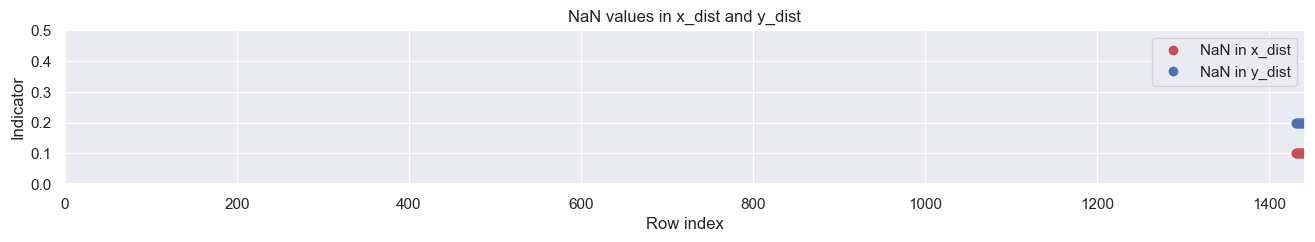

Empty DataFrame
Columns: [Unnamed: 0, bp04_x, bp04_y, bp05_x, bp05_y, bp06_x, bp06_y, bp07_x, bp07_y, bp18_x, bp18_y, bp19_x, bp19_y, bp20_x, bp20_y, bp21_x, bp21_y, fcl_deg_L, fcl_deg_R, tip_deg_L, tip_deg_R, SI_L, SI_R]
Index: []

[0 rows x 23 columns]
No. of NaN in tip_deg_L: 10
No. of NaN in tip_deg_R: 10
No. of NaN in SI_L: 33
No. of NaN in SI_R: 41
No. of NaN in SI_L_filtered: 41
No. of NaN in SI_R_filtered: 48


In [108]:
'''REMOVE THE JUMPY POINTS FROM THE TRAJECTORY DATAFRAME'''

# set a threshold for jumpy points
threshold = 200

# First, replce the points that do not change in consecutive frames with NA.
df_trajectory.loc[(df_trajectory["x_dist"].diff() == 0) & (df_trajectory["y_dist"].diff() == 0), ["x_dist", "y_dist"],] = np.nan


# replace jumpy points with NA
df_trajectory.loc[
    (np.abs(df_trajectory["x_dist"] - df_trajectory["x_dist"].shift()) > threshold)
    | (np.abs(df_trajectory["y_dist"] - df_trajectory["y_dist"].shift()) > threshold),
    ["x_dist", "y_dist"],
] = np.nan

'''Check where are the NaN frames'''
# Get the boolean mask where True indicates NaN values
nan_mask_x = df_trajectory['x_dist'].isna()
nan_mask_y = df_trajectory['y_dist'].isna()

# Get the indices of NaN values
nan_indices_x = np.where(nan_mask_x)[0]
nan_indices_y = np.where(nan_mask_y)[0]

print("NaN indices in 'x_dist':", nan_indices_x)
print("NaN indices in 'y_dist':", nan_indices_y)

nan_rows_x = df_trajectory['x_dist'].isna()
nan_rows_y = df_trajectory['y_dist'].isna()

plt.figure(figsize=(16, 2))

# Check if there are any NaN values in x_dist before plotting
if nan_rows_x.any():
    plt.plot(np.where(nan_rows_x)[0], [.1]*sum(nan_rows_x), 'ro', label='NaN in x_dist')

# Check if there are any NaN values in y_dist before plotting
if nan_rows_y.any():
    plt.plot(np.where(nan_rows_y)[0], [.2]*sum(nan_rows_y), 'bo', label='NaN in y_dist')

plt.xlabel('Row index')
plt.ylabel('Indicator')
plt.title('NaN values in x_dist and y_dist')

# Set the limits of the x-axis to match the length of the DataFrame
plt.xlim(0, len(df_trajectory))
plt.ylim(0, .5)

plt.legend()
plt.show()


'''TRANSFORM THE ANTENNAL DATA'''

# Replace missing values with NaN
df_antennal_si = df_antennal_sample.replace('', np.nan)

# For each column, create a numpy array and add it to the global namespace
for col in df_antennal_si.columns:
    globals()[col] = df_antennal_si[col].to_numpy()


#Show the name of thew newly created numpy files from each column of te imported data farme.
print(df_antennal_si.head(0))

# Show the number of NaNs in the antennal smapling angles
print(f"No. of NaN in tip_deg_L: {sum(np.isnan(tip_deg_L))}")
print(f"No. of NaN in tip_deg_R: {sum(np.isnan(tip_deg_R))}")
print(f"No. of NaN in SI_L: {sum(np.isnan(SI_L))}")
print(f"No. of NaN in SI_R: {sum(np.isnan(SI_R))}")

#Convert extreme values into NaN
mean_L = np.nanmean(SI_L)
std_L = np.nanstd(SI_L)
SI_L_filtered = np.where(SI_L > mean_L + 3*std_L, np.nan, SI_L)

mean_R = np.nanmean(SI_R)
std_R = np.nanstd(SI_R)
SI_R_filtered = np.where(SI_R > mean_R + 3*std_R, np.nan, SI_R)

print(f"No. of NaN in SI_L_filtered: {sum(np.isnan(SI_L_filtered))}")
print(f"No. of NaN in SI_R_filtered: {sum(np.isnan(SI_R_filtered))}")

'''CONVERT THE DLC DATA INTO A NUMPY ARRAY'''

# take cross sections of df to create numpy arrays of x data and y data
x_data = df_dlc.xs('x', level="coords", axis=1).values
y_data = df_dlc.xs('y', level="coords", axis=1).values
likelihood_data = df_dlc.xs('likelihood', level="coords", axis=1).values

# stack the x and y data on top of each other to create 3D numpy array
dlc_data_numpy = np.concatenate((
            np.expand_dims(x_data, axis=-1), 
            np.expand_dims(y_data, axis=-1),
            np.expand_dims(likelihood_data, axis=-1)), axis=-1)



***
**Have the first look at the data**

(0.0, 3000.0)

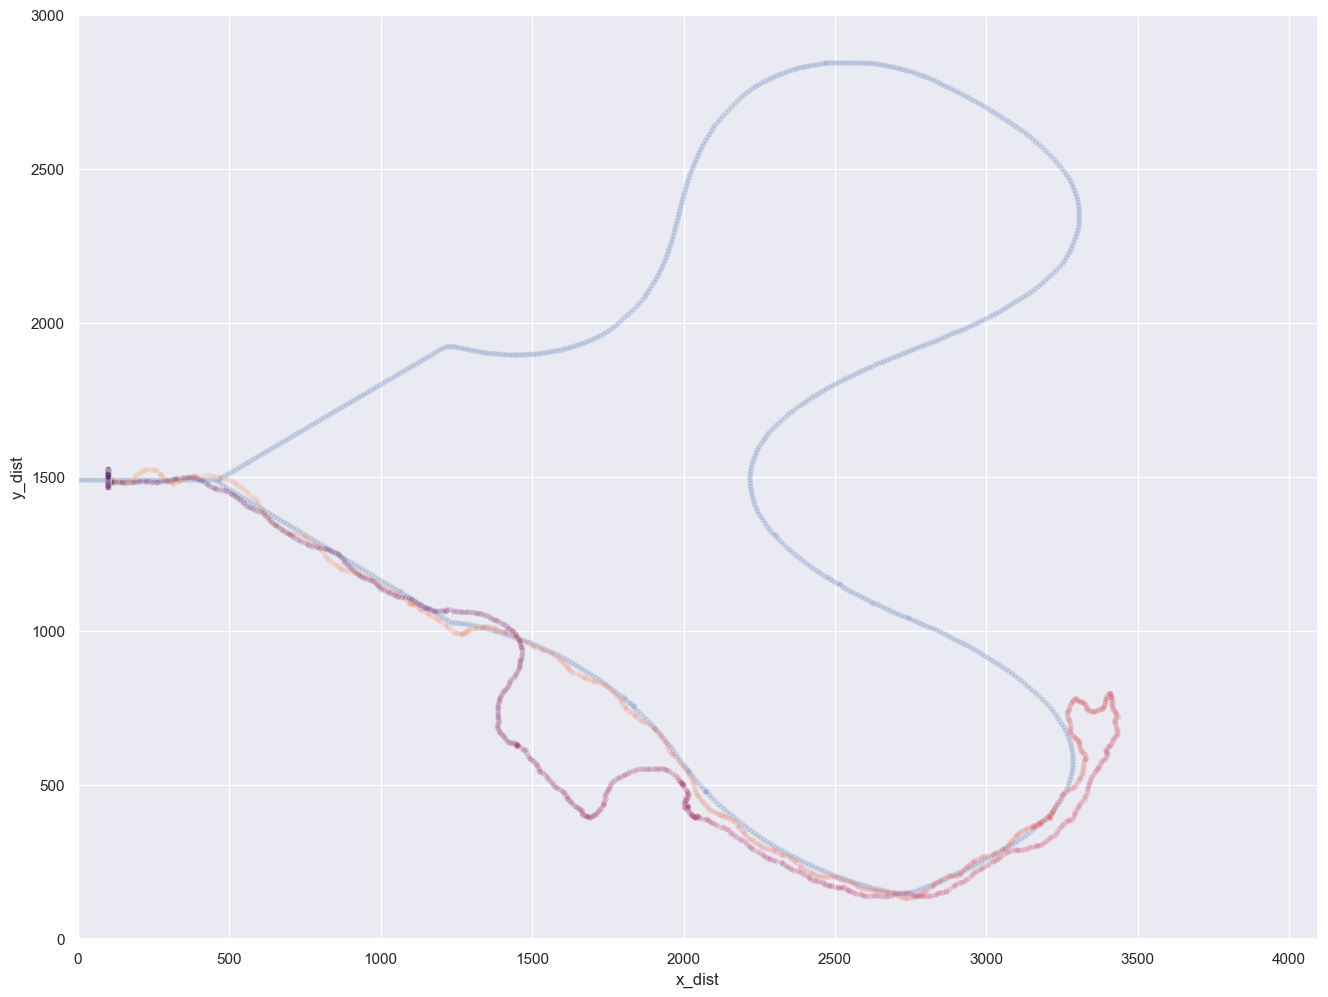

In [109]:
sns.set_theme(style="darkgrid")
%matplotlib inline

# Plot the data
fig_trajectory, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(x=df_trail[:,0], y=df_trail[:,1], size=1, alpha=0.2, legend=None)
sns.scatterplot(
    data=df_trajectory,
    x="x_dist",
    y="y_dist",
    hue=df_trajectory.index,
    palette="flare",
    size=1,
    alpha=0.2,
    legend=None,
)

plt.xlim(0, 4096)
plt.ylim(0, 3000)


**Check whether the conversion of DLC data has happened without any glitch.**

In [137]:
pd.set_option('display.max_columns', None)
df_dlc.loc[[500]]

scorer    DLC_resnet101_BU_trailApr4shuffle1_1030000                         \
bodyparts                                          h                          
coords                                             x           y likelihood   
500                                       139.781036  112.807098   0.750356   

scorer                                                                        \
bodyparts           t                                p                         
coords              x          y likelihood          x          y likelihood   
500        122.595108  103.79258   0.279134  86.574074  93.311127   0.946492   

scorer                                                                        \
bodyparts          g                               la0                         
coords             x          y likelihood           x          y likelihood   
500        51.488201  81.523888   0.865586  185.235428  99.812889   0.833834   

scorer                                                               \
bodyparts        la1                                la2               
coords             x           y likelihood           x           y   
500        179.98436  101.948227   0.972724  173.696747  103.379837   

scorer                                                               \
bodyparts                    la3                                la4   
coords    likelihood           x           y likelihood           x   
500         0.720816  157.453827  100.129044   0.926753  142.100342   

scorer                                                                         \
bodyparts                               lfl1                             lfl2   
coords              y likelihood           x          y likelihood          x   
500        107.348167   0.859335  133.574341  80.648964   0.970009  115.64801   

scorer                                                                         \
bodyparts                              lfl3                              lml1   
coords             y likelihood           x          y likelihood           x   
500        86.863327   0.238424  105.761002  90.006378   0.847214  108.705612   

scorer                                                                        \
bodyparts                              lml2                             lml3   
coords             y likelihood           x          y likelihood          x   
500        46.654259   0.879699  102.270042  75.856522   0.779435  96.671844   

scorer                                                                       \
bodyparts                             lhl1                             lhl2   
coords             y likelihood          x          y likelihood          x   
500        88.614159   0.636314  54.333195  51.988358   0.897194  81.418152   

scorer                                                                       \
bodyparts                             lhl3                              ra0   
coords             y likelihood          x         y likelihood           x   
500        74.880516   0.763236  90.434967  87.00441   0.491562  153.703964   

scorer                                                               \
bodyparts                                ra1                          
coords              y likelihood           x           y likelihood   
500        166.304428   0.860046  153.539017  158.113586   0.520452   

scorer                                                                \
bodyparts         ra2                                ra3               
coords              x           y likelihood           x           y   
500        151.513718  153.943542   0.618589  140.169998  137.368011   

scorer                                                               \
bodyparts                    ra4                               rfl1   
coords    likelihood           x           y likelihood           x   
500          0.90116  135.434357  118.152756   0.612816  132.538025   

scorer 

In [138]:
print(dlc_data_numpy[500])

[[139.78103638 112.80709839   0.75035572]
 [122.59510803 103.79257965   0.27913448]
 [ 86.57407379  93.31112671   0.94649231]
 [ 51.48820114  81.52388763   0.86558646]
 [185.23542786  99.8128891    0.83383417]
 [179.98435974 101.94822693   0.97272408]
 [173.69674683 103.37983704   0.7208156 ]
 [157.4538269  100.12904358   0.92675263]
 [142.1003418  107.34816742   0.85933465]
 [133.57434082  80.64896393   0.97000879]
 [115.64801025  86.86332703   0.23842403]
 [105.76100159  90.00637817   0.8472144 ]
 [108.70561218  46.65425873   0.87969917]
 [102.27004242  75.85652161   0.7794348 ]
 [ 96.67184448  88.61415863   0.63631386]
 [ 54.33319473  51.98835754   0.89719439]
 [ 81.41815186  74.88051605   0.76323605]
 [ 90.43496704  87.00440979   0.49156189]
 [153.70396423 166.3044281    0.86004621]
 [153.53901672 158.11358643   0.52045184]
 [151.51371765 153.94354248   0.61858922]
 [140.16999817 137.36801147   0.90116024]
 [135.43435669 118.15275574   0.61281627]
 [132.5380249  128.90489197   0.84

**Optional: Make animation of the areana view of the ant**

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1152x864 -pix_fmt rgba -r 50 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ant_trajectory.mp4


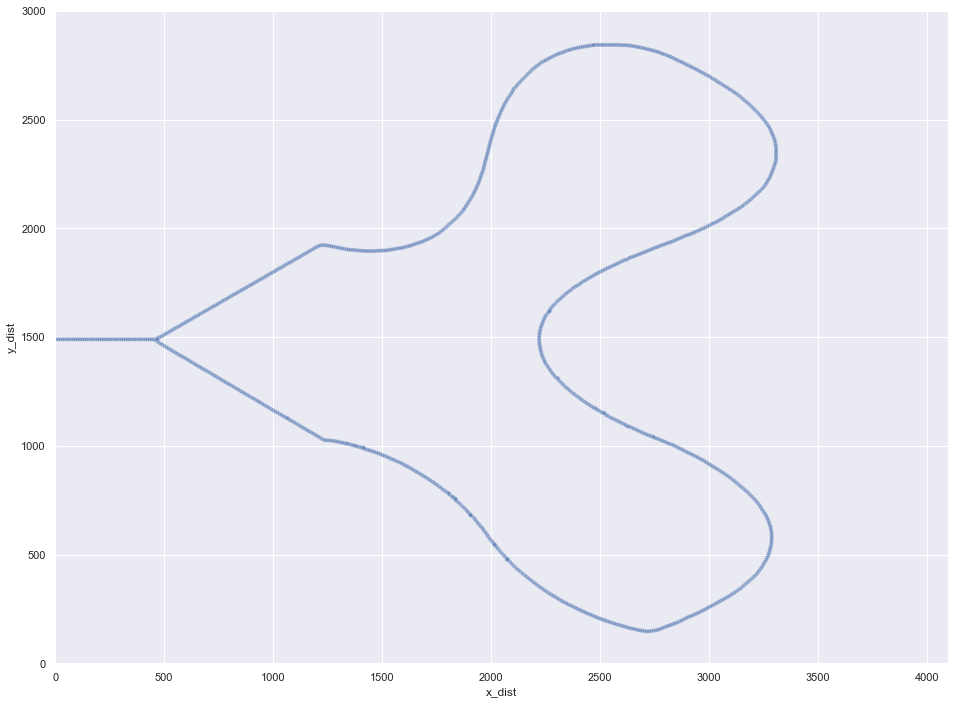

In [137]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(16, 12))

# The scatterplot of the trail will be constant, so we plot it once
sns.scatterplot(x=trail_x_loc, y=trail_y_loc, size=1, alpha=0.5, legend=None)

# Here we set up the Animation writer - you can adjust the bitrate as needed
writer = animation.FFMpegWriter(fps=50)

def animate(i):
    # This removes the previous frame's trajectory points
    plt.gca().collections[1:] = []
    # Then plot the new points
    sns.scatterplot(
        data=df_trajectory.iloc[:i],
        x="x_dist",
        y="y_dist",
        color='black',
        size=1,
        alpha=0.2,
        legend=None,
    )
    plt.xlim(0, 4096)
    plt.ylim(0, 3000)

ani = animation.FuncAnimation(fig, animate, frames=len(df_trajectory), repeat=False)

ani.save("ant_trajectory.mp4", writer=writer)


***
#### *Optional step for filtering antennal data; I did NOT use it in this pipeline*

Fill up the missing values of SI_L and SI_R taking into account of the values flanking the missing values and put them in two separate numpy array SI_L_filled and SI_R_filled.

In [5]:
'''GET RID OF NaNs'''

# convert numpy array to pandas dataframe
df_SI_L = pd.DataFrame(SI_L_filtered)
df_si_l_filled = df_SI_L.interpolate(method ='linear', limit_direction ='both')
# convert dataframe back to numpy array
si_l_filled = df_si_l_filled.values

df_SI_R = pd.DataFrame(SI_R_filtered)
df_si_r_filled = df_SI_R.interpolate(method ='linear', limit_direction ='both')
# convert dataframe back to numpy array
si_r_filled = df_si_r_filled.values

print(f"No. of NaN in SI_L: {sum(np.isnan(SI_L))}")
print(f"No. of NaN in SI_R: {sum(np.isnan(SI_R))}")

print(f"No. of NaN in SI_L_filtered: {sum(np.isnan(SI_L_filtered))}")
print(f"No. of NaN in SI_R_filtered: {sum(np.isnan(SI_R_filtered))}")

print(f"No. of NaN in SI_L_filled: {sum(np.isnan(si_l_filled))}")
print(f"No. of NaN in SI_R_filled: {sum(np.isnan(si_r_filled))}")

No. of NaN in SI_L: 88
No. of NaN in SI_R: 59
No. of NaN in SI_L_filtered: 113
No. of NaN in SI_R_filtered: 84
No. of NaN in SI_L_filled: [0]
No. of NaN in SI_R_filled: [0]


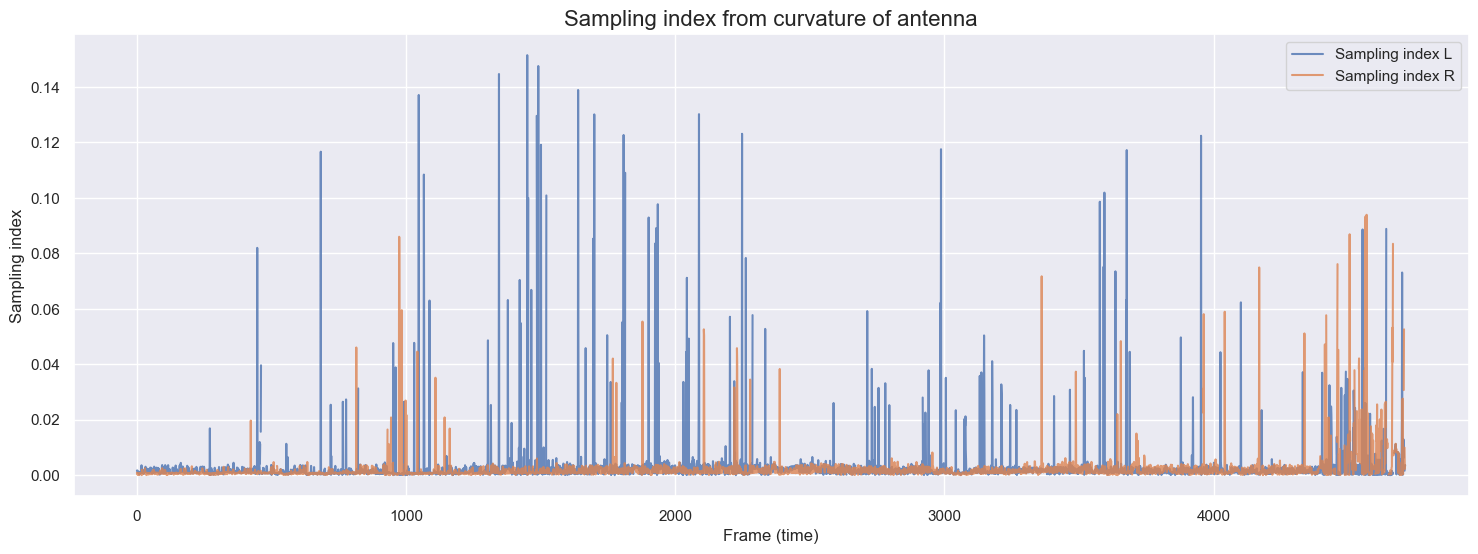

In [175]:
'''PLOT'''

plt.figure(figsize=(18, 6))
plt.plot(SI_L_filtered, label='Sampling index L', alpha=0.8)
plt.plot(SI_R_filtered, label='Sampling index R', alpha=0.8)
#plt.xlim(0, len(si_l_filled))
#plt.xlim(0, 500)

plt.xlabel('Frame (time)')
plt.ylabel('Sampling index')
plt.title('Sampling index from curvature of antenna', fontsize = 16)
plt.legend()
plt.grid(True)
plt.show()


**Run the code snippet below if you want ot get an interactive plot.**

In [14]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'

# Get the color palette
colors = sns.color_palette()

# Flatten the numpy arrays
si_l_filled_flat = SI_L_filtered.flatten()
si_r_filled_flat = SI_R_filtered.flatten()

# Create a trace for si_l_filled
trace_si_l_filled = go.Scatter(
    x = np.arange(len(si_l_filled_flat)),
    y = si_l_filled_flat,
    mode = 'lines',
    name = 'si_l_filled',
    line = dict(color='rgba'+str(tuple(int(c*255) for c in colors[0])+ (0.8,)))  # 80% transparency
)

# Create a trace for si_r_filled
trace_si_r_filled = go.Scatter(
    x = np.arange(len(si_r_filled_flat)),
    y = si_r_filled_flat,
    mode = 'lines',
    name = 'si_r_filled',
    line = dict(color='rgba'+str(tuple(int(c*255) for c in colors[1])+ (0.8,)))  # 80% transparency
)

# Create a figure and add the traces
fig = go.Figure(data=[trace_si_l_filled, trace_si_r_filled])

# Set the title and labels
fig.update_layout(
    title='SI_L_filled and si_r_filtered over Time',
    xaxis_title='Frame',
    yaxis_title='Sampling index',
        autosize=False,  # Disable autosize
    width=1000,  # Set figure width
    height=400,  # Set figure height
    legend=dict(
        x=0.1,  # x position of top-left corner of legend
        y=0.9,  # y position of top-left corner of legend
    )
)

# Show the figure
fig.show()

***
## STEP 3: Get basic statistics
**Measure the distance of the ant from the trail and it's speed in every frame**

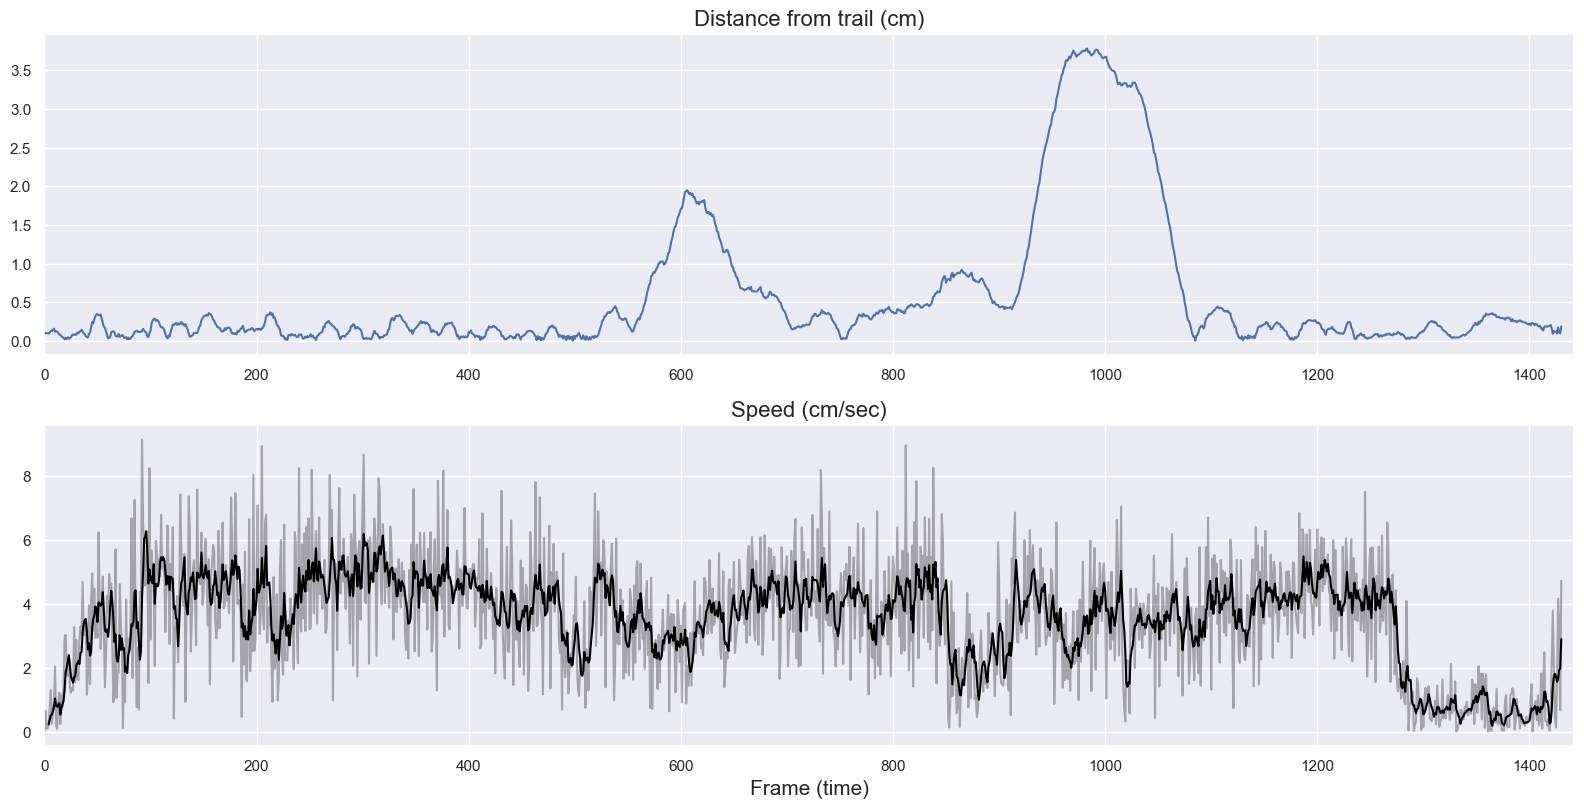

In [110]:
dist_from_trail = []
for i in range(len(df_trajectory)):
    # calculate the distance of each point on the trail to the ant's current location
    all_dist = np.sqrt(
        (trail_x_loc - df_trajectory.iloc[i, 0]) ** 2
        + (trail_y_loc - df_trajectory.iloc[i, 1]) ** 2
    )
    min_dist = all_dist.min()

    dist_from_trail.append(min_dist)

dist_from_trail = np.array(dist_from_trail)
dist_from_trail_cm = dist_from_trail/97

# Calculate speed

# compute the differences between successive rows for 'x_dist' and 'y_dist'
dx = df_trajectory['x_dist'].diff().values
dy = df_trajectory['y_dist'].diff().values

# compute the distance traveled between every two points
speed = np.sqrt(dx[1:]**2 + dy[1:]**2)
speed = np.insert(speed, 0, 0)

#convert the speed in cm/sec from pixel/frame (97 pixel = 1 cm, video recorded at 50 fps)
# If the ant moves x pixels in 1 frame, it moves 50x px in 1 sec (50 frames)
# 97 px = 1 cm
# 50x px = 50x/97 cm

#speed in cm/sec
speed_cm_sec = 50*speed/ 97

# Make a rolling average of speed JUST for plotting.
speed_series = pd.Series(speed_cm_sec)
speed_run_avg = speed_series.rolling(window=5).mean()  # Change the window size as needed

#Plot
fig, axs = plt.subplots(2, figsize=(16,8))

axs[0].plot(dist_from_trail_cm)
axs[0].set_title("Distance from trail (cm)", fontsize=16)
axs[0].set_xlim([0, len(df_trajectory)])

axs[1].plot(speed_cm_sec, color='black', alpha=0.3)
axs[1].plot(speed_run_avg, color='black', label='Running Average')
axs[1].set_title("Speed (cm/sec)", fontsize=16)
axs[1].set_xlim([0, len(df_trajectory)])


# Display the plots
plt.tight_layout()
plt.xlabel('Frame (time)', fontsize=15)
plt.show()

#### Make animation of Distance from trail and speed stat.

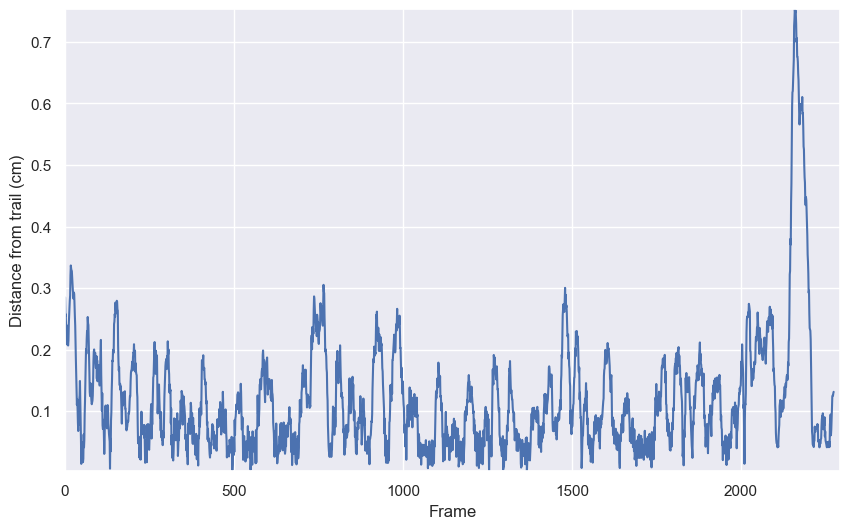

In [56]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Setup the plot
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Frame')
ax.set_ylabel('Distance from trail (cm)')
ax.set_xlim(0, len(dist_from_trail_cm))

# Handle NaN or Inf values in y-limits
finite_values = dist_from_trail_cm[np.isfinite(dist_from_trail_cm)]
if len(finite_values) > 0:
    ax.set_ylim(np.min(finite_values), np.max(finite_values))
else:
    ax.set_ylim(0, 1)  # Default y-limits if all values are NaN or Inf

# Initialize the line object
ln, = plt.plot([], [], 'b-', animated=True)

# Initialization function for the animation
def init():
    ln.set_data([], [])
    return ln,

# Update function for the animation
def update(frame):
    ln.set_data(np.arange(frame), dist_from_trail_cm[:frame])
    return ln,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(dist_from_trail_cm), init_func=init, blit=True)

# Set up the writer object
writer = FFMpegWriter(fps=50, metadata=dict(artist='Souvik Mandal'), bitrate=1800)

# Save the animation
ani.save('animated_plot.mp4', writer=writer)

# Display the animation
plt.show()


RuntimeError: Passing in values for arguments fps, codec, bitrate, extra_args, or metadata is not supported when writer is an existing MovieWriter instance. These should instead be passed as arguments when creating the MovieWriter instance.

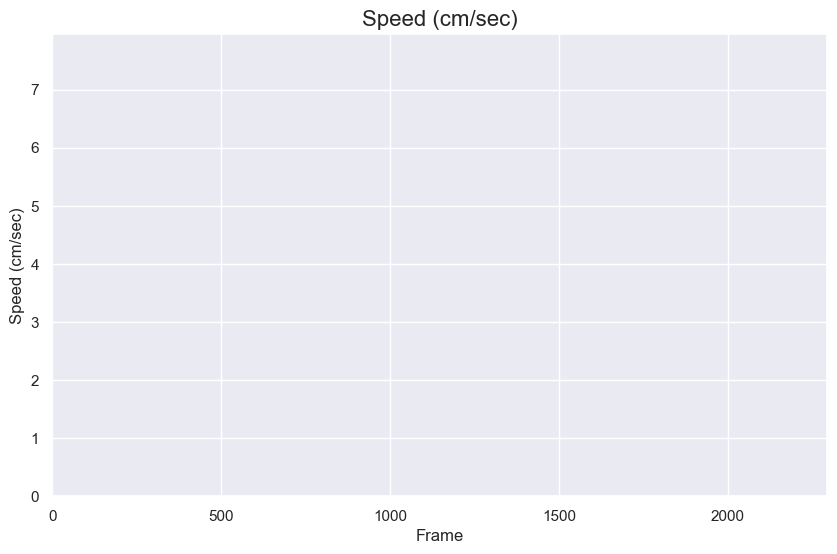

In [60]:
import matplotlib.animation as animation


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set labels for the axes and the title
ax.set_xlabel('Frame')
ax.set_ylabel('Speed (cm/sec)')
ax.set_title("Speed (cm/sec)", fontsize=16)

# Set the limits of the plot
ax.set_xlim(0, len(speed_cm_sec))
ax.set_ylim(np.nanmin(speed_cm_sec), np.nanmax(speed_cm_sec))

# Initialize the line objects
ln1, = plt.plot([], [], 'black', alpha=0.3, animated=True)
ln2, = plt.plot([], [], 'black', animated=True)

def init():
    return ln1, ln2,

def update(frame):
    ln1.set_data(np.arange(frame), speed_cm_sec[:frame])
    ln2.set_data(np.arange(frame), speed_run_avg[:frame])
    return ln1, ln2,

ani = animation.FuncAnimation(fig, update, frames=len(speed_cm_sec),
                              init_func=init, blit=True)

# To save the animation
ani.save('antmovie220714151709_ant12_trail2_144633_animated_speed.mp4', writer='ffmpeg', fps=50)

plt.show()


* **Measure the body length of the ant. We will save the mean and std dev. in the file name of the output csv and use this later for meta-analysis.**
* **Mark each frame as “GOOD” and “BAD” depending on the body length of the ant from DLC data and save it in a numpy array `frame_quality`.**

Total number of GOOD frames is 1351
Total number of BAD frames is 91


/var/folders/xl/3brx3y1d71n15p4qb7psl0580000gq/T/ipykernel_16333/2067293432.py:48: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f"Mode: {round(mode(body_length_array).mode[0],3):<{padding_length}}"


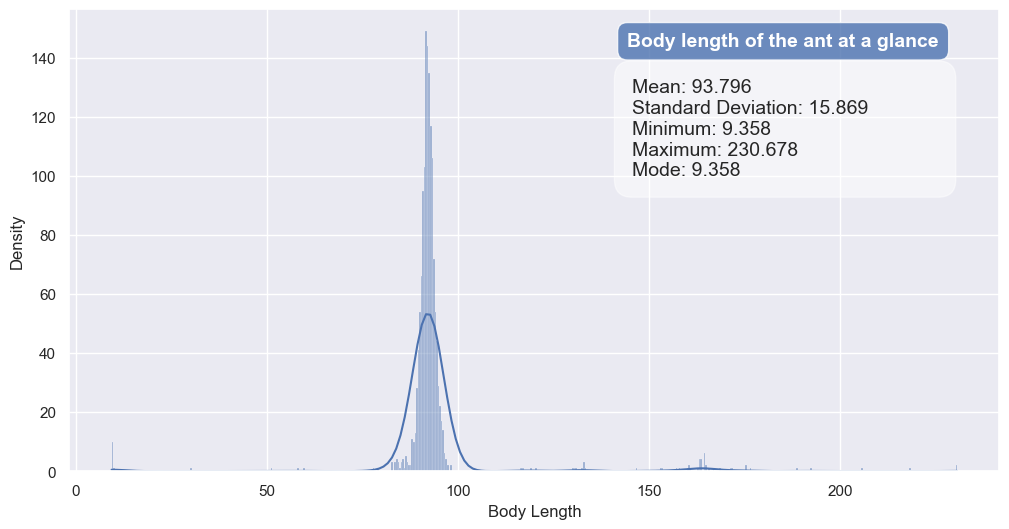

In [111]:
'''GET THE BODY LENGTH STATISTICS'''

def distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

bl_file = []
for i in range(len(df_trajectory)):
    hd, tx, pl, gt = dlc_data_numpy[i, 0][:2], dlc_data_numpy[i, 1][:2], dlc_data_numpy[i, 2][:2], dlc_data_numpy[i, 3][:2]
    body_length = distance(hd, tx) + distance(tx, pl) + distance(pl, gt)
    bl_file.append(body_length)
    
body_length_array = np.array(bl_file)
body_length_mean = round(np.mean(body_length_array),3)
body_length_std = round(np.std(body_length_array),3)

'''MARK EACH FRAME AS "GOOD" AND "BAD" DEPENDING ON THE BODY LENGTH OF THE ANT FROM DLC DATA'''

# Calculate the lower and upper bounds for the "GOOD" range
lower_bound = body_length_mean - body_length_std/2
upper_bound = body_length_mean + body_length_std/2

# Create an empty array for frame_quality
frame_quality = np.empty_like(body_length_array, dtype=object)

# Fill frame_quality based on the conditions
for i in range(len(body_length_array)):
    if lower_bound <= body_length_array[i] <= upper_bound:
        frame_quality[i] = "GOOD"
    else:
        frame_quality[i] = "BAD"

good_count = np.sum(frame_quality == 'GOOD')
bad_count = np.sum(frame_quality == 'BAD')
print("Total number of GOOD frames is", format(good_count))
print("Total number of BAD frames is", format(bad_count))


'''PLOT'''

# determine the padding length
padding_length = 19

# padded statistics
statistics_text = f"Mean: {body_length_mean:<{padding_length}}\n" \
                  f"Standard Deviation: {body_length_std:<{padding_length}}\n" \
                  f"Minimum: {round(np.min(body_length_array),3):<{padding_length}}\n" \
                  f"Maximum: {round(np.max(body_length_array),3):<{padding_length}}\n" \
                  f"Mode: {round(mode(body_length_array).mode[0],3):<{padding_length}}"

# Distribution plot with KDE line
plt.figure(figsize=(12, 6))
sns.histplot(body_length_array, kde=True)
plt.xlabel("Body Length")
plt.ylabel("Density")

# Add the heading as a separate text box
heading_text = "Body length of the ant at a glance"
heading_bbox = dict(boxstyle='round', facecolor=sns.color_palette()[0], alpha=0.8, pad=0.5)
plt.text(0.60, 0.95, heading_text, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=heading_bbox, color='white', weight='bold')

# Add the remaining statistics as a text box
statistics_bbox = dict(boxstyle='round', facecolor='white', alpha=0.5, pad=0.9)
plt.text(0.605, 0.85, statistics_text, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=statistics_bbox)

plt.show()


***
**If you want to test the pipeline on a video, first extract all the frames as images from the video and then define the path to the extracted images.**
* Just uncheck the following cell (delete ''' in the first and last line) and run it.

In [155]:
'''
video = cv2.VideoCapture('/Users/som716/Documents/04_trail_tracking_ants/BU_trail/videos/antmovie220714151709_ant12_trail2_144633_CCW.avi')

# Create a directory to save the frames
if not os.path.exists('frames'):
    os.makedirs('frames')

# Loop through the frames of the video
frame_count = 0
while True:
    # Read the next frame
    ret, frame = video.read()

    # If the frame was not successfully read, break out of the loop
    if not ret:
        break

    # Save the frame as an image file
    frame_filename = f"frame{frame_count:04d}.jpg"
    frame_filepath = os.path.join('frames', frame_filename)
    cv2.imwrite(frame_filepath, frame)

    # Increment the frame count
    frame_count += 1

# Release the video file
video.release()
'''


**Define the folder containing the frames & the folder that will contain the generated frames**

In [62]:
img_folder = '/Users/souvikmandal/Documents/04_trail_tracking_ants/BU_trail/data_all/20220714/frames_antmovie220714151709_ant12_trail2_144633_CCW/'
new_img_folder = '/Users/souvikmandal/Documents/04_trail_tracking_ants/BU_trail/data_all/20220714/frames_antmovie220714151709_ant12_trail2_144633_CCW/00_marked_frames'


***
***
## STEP 4: MAKING THE FINAL CSV OUTPUT WITH COMPOSITE DATA

### Now, if the ant is near the trail, we want to know how the ant percieve the trail.

**For that, first we need to know the orientation of the ant's body axis (angle) and the position of its antennae relative to the trail.** 

**Steps:**
1. Using the x & y coordinate of the ants position from the trajectory data, make a 200/200 px bounding box around the coordinate for each frame.
1. Search for any trail points within this boundary box and make a list of points if any.
1. Convert the global coordinate of these points (4096 / 3000 px) into the local coordinates (in respect to the 200 / 200 px box).
1. Measure the angle made by the ants body axis (defined by the best fit straightline made by the coordinates of the head, thorax, petiole and gaster) and the trail (defined by the coordinates of the point on the trail closest to the head and the point closest to gaster).
1. Add confidence level of the body axis from the dlc likelihood data.
1. Add the curvatute index of the trail defined by all the points in between the two points closest to the head and gaster.
1. Get the minimum distance of head and gaster from the trail: if this value is positive, it means the bodypart (or the ant) is on the right side of the trail. Therefore, the ant percieves that the trail is on its left side. Negetive value demarcates that the ant percieves the trail on its right side.
1. And finally, add all the data from each frame in to a dataframe with the following column structure:

        ['frame_quality': Each frame is marked as “GOOD” and “BAD” deciding whether to take data from this frame for any statistical analysis,
        'trajectory_x': The x coordinate of the ant's overall body position in the arena (center of mass of the ant)
        'trajectory_y': The y coordinate of the ant's overall body position in the arena (center of mass of the ant)
        'head_x', 'head_y': The x & y coordinate of the tip of the ant's head from DLC data
        'gaster_x', 'gaster_y': The x & y coordinate of the end of the ant's gaster from DLC data
        'bp04_x', 'bp04_y': The x & y coordinate of the tip of the left antenna
        'bp05_x', 'bp05_y': The x & y coordinate of the 2nd point on left antenna from the tip of left antenna
        'bp06_x', 'bp06_y': The x & y coordinate of the 3rd point on left antenna from the tip of left antenna
        'bp07_x', 'bp07_y': The x & y coordinate of the 4th point on left antenna from the tip of left antenna
        'bp18_x', 'bp18_y': The x & y coordinate of the tip of the right antenna
        'bp19_x', 'bp19_y': The x & y coordinate of the 2nd point on right antenna from the tip of right antenna
        'bp20_x', 'bp20_y': The x & y coordinate of the 3rd point on right antenna from the tip of right antenna
        'bp21_x', 'bp21_y': The x & y coordinate of the 4th point on right antenna from the tip of right antenna
        'gross_dist': Distance between the ant’s center of mass and the nearest point on the trail,
        'speed': speed of the ant, derived from the trajectory data,
        'near_trail': Whether the ant and trail both in the video frame: binary (YES/ NO),
        'trail_curvature': The curvature of the trail nearby the ant
        'trail_point_Rsq': The R square value of the points constituting the trail in between the ant's head and gaster tip.
        'angle_on_trail': The angle that the best fit lines of the points constituting the trail makes between the frame and the previous frame.
        'dist_head': Distance of head tip from the trail: (in pixel),
        'dist_gast': Distance of head end from the gaster: (in pixel),
        'ant_trail_ang': The angle made by the ant's body axis and the nearby trail: ranges from:-90 deg to +90 deg
        'orientation': Orientaion of the ant in respect to the trail: categorical (ON, LEFT, RIGHT, CROSSING),
        'phase': Whether the ant is approaching or departing the trail: categorical (Departing, Approaching, Parallel to)
        'min_dist_l_antn': Minimal distance between the trail and the tip of the left antenna
        'min_dist_r_antn': Minimal distance between the trail and the tip of the right antenna
        'la_overlap': Whether left antenna overlapping with trail: binary (YES, NO)
        'ra_overlap': Whether right antenna overlapping with trail: binary (YES, NO)
        'la_ovlp_x': if the left antenna overlapping the trail, the x coordinate of the overlap
        'la_ovlp_y': if the left antenna overlapping the trail, the y coordinate of the overlap
        'ra_ovlp_x': if the right antenna overlapping the trail, the x coordinate of the overlap
        'ra_ovlp_y': if the right antenna overlapping the trail, the y coordinate of the overlap
        'tip_deg_L': The angle on the tip of the left antenna
        'fcl_deg_L': The angle on the middle of the funiculus of left antenna
        'tip_deg_R': The angle on the tip of the right antenna
        'fcl_deg_R': The angle on the middle of the funiculus of right antenna
        'SI_L_ang': Sampling index of left antenna from angle
        'SI_R_ang': Sampling index of right antenna from angle
        'tip_deg_L_apl', 'fcl_deg_L_apl': Tip and funiculus angle in degrees from curvature pipeline LEFT antenna
        'tip_deg_R_apl', 'fcl_deg_R_apl': Tip and funiculus angle in degrees from curvature pipeline RIGHT antenna
        'SI_L_cv': Getting the sampling index of LEFT antenna from the overall curvature of the antennal funiculus
        'SI_R_cv': Getting the sampling index of RIGHT antenna from the overall curvature of the antennal funiculus
        ]
        

**Create an empty dataframe to contain all the generated data.**

In [112]:
stat_df = pd.DataFrame(
    columns=[
        "frame_quality",
        "trajectory_x","trajectory_y",
        "head_x", "head_y",
        "gaster_x", "gaster_y",
        "bp04_x", "bp04_y",
        "bp05_x", "bp05_y",
        "bp06_x", "bp06_y",
        "bp07_x", "bp07_y",
        "bp18_x", "bp18_y",
        "bp19_x", "bp19_y",
        "bp20_x", "bp20_y",
        "bp21_x", "bp21_y",
        "gross_dist",
        "speed",
        "near_trail",
        "trail_curvature",
        "trail_point_Rsq",
        "angle_on_trail",
        "dist_head",
        "dist_gast",
        "ant_trail_ang",
        "orientation",
        "phase",
        "MinDist_L_atn",
        "MinDist_R_atn",
        "la_overlap",
        "ra_overlap",
        "la_ovlp_x","la_ovlp_y",
        "ra_ovlp_x","ra_ovlp_y",
        "tip_deg_L", "fcl_deg_L", 
        "tip_deg_R", "fcl_deg_R",
        "tip_deg_L_apl", "fcl_deg_L_apl",
        "tip_deg_R_apl", "fcl_deg_R_apl",
        "SI_L_ang", "SI_R_ang",
        "SI_L_cv", "SI_R_cv"
    ]
)
stat_df

Empty DataFrame
Columns: [frame_quality, trajectory_x, trajectory_y, head_x, head_y, gaster_x, gaster_y, bp04_x, bp04_y, bp05_x, bp05_y, bp06_x, bp06_y, bp07_x, bp07_y, bp18_x, bp18_y, bp19_x, bp19_y, bp20_x, bp20_y, bp21_x, bp21_y, gross_dist, speed, near_trail, trail_curvature, trail_point_Rsq, angle_on_trail, dist_head, dist_gast, ant_trail_ang, orientation, phase, MinDist_L_atn, MinDist_R_atn, la_overlap, ra_overlap, la_ovlp_x, la_ovlp_y, ra_ovlp_x, ra_ovlp_y, tip_deg_L, fcl_deg_L, tip_deg_R, fcl_deg_R, tip_deg_L_apl, fcl_deg_L_apl, tip_deg_R_apl, fcl_deg_R_apl, SI_L_ang, SI_R_ang, SI_L_cv, SI_R_cv]
Index: []

[0 rows x 54 columns]

#### Step 1: Get the four x and y values that will define a 200x200 px boundary around the ant in each frame.

Let's name thse points low_x, low_y, high_x, high_y.
* Point A (left bottom) should be low_x, low_y
* Point B (right bottom) should be high_x, low_y
* Point C (right top) should be high_x, high_y
* Point D (left top) should be low_x, high_y


**Create the dataframe containing the boundng box data.**

In [113]:

#Define bounding box at every frame (frame index defined in i)
bound_box = pd.DataFrame(columns=['centerx', 'centery', 'lowx', 'lowy', 'highx', 'highy'])

for j in range(len(df_trajectory)):
    centerx = df_trajectory.iloc[j,0]
    centery = df_trajectory.iloc[j,1]
    if not np.isnan(centerx):
        lowx = int(max(0,centerx-100))
        lowy = int(max(0,centery-100))
        highx = int(min(4096,centerx+100))
        highy = int(min(3000,centery+100))
    else:
        lowx, lowy, highx, highy = np.nan, np.nan, np.nan, np.nan

    bound_box.loc[j] = [centerx, centery, lowx, lowy, highx, highy]


#### Make functions
1. **to calculate the minimal distance of the antennae and trail.**
1. **to get all the points in between two points. We will use it later to find the curvature of the part of the trail closest to the ant.**
1. **to rotate the points on trail so that we can calculate the curvature.**
1. **to get the angles between three points, which we will use to calculate the sampling index.**


In [101]:
#Function 1
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def calculate_line_distance(line1, line2):
    # Line1 and Line2 are defined as [point1, point2]
    # Calculate the minimum distance between all four combinations of endpoints
    distances = [calculate_distance(line1[0], line2[0]),
                 calculate_distance(line1[0], line2[1]),
                 calculate_distance(line1[1], line2[0]),
                 calculate_distance(line1[1], line2[1])]
    return min(distances)

def calculate_min_distance(set1, set2):
    min_distance = float('inf')
    for i in range(len(set1)-1):
        for j in range(len(set2)-1):
            line1 = [set1[i], set1[i+1]]
            line2 = [set2[j], set2[j+1]]
            distance = calculate_line_distance(line1, line2)
            if distance < min_distance:
                min_distance = distance
    return min_distance

# Function 2
def is_between(a, b, c):
    """Check if point c is within the rectangle defined by a and b"""
    return min(a[0], b[0]) <= c[0] <= max(a[0], b[0]) and min(a[1], b[1]) <= c[1] <= max(a[1], b[1])

# Function 3
def translate_and_rotate(trail_cp_gast, trail_cp_head, points_in_between_array):
    # Define the origin
    origin = np.array([0, 200])
    
    # Translate points such that trail_cp_gast is at the origin
    translation_vector = origin - trail_cp_gast
    trail_cp_head_translated = trail_cp_head + translation_vector
    points_in_between_array_translated = points_in_between_array + translation_vector
    
    # Compute angle to rotate points so trail_cp_head lies on y-axis
    # Vector from trail_cp_gast_translated (origin) to trail_cp_head_translated
    vector_to_head = trail_cp_head_translated - origin

    # Since we're working in a different coordinate system, the angle will be with respect to the (0, -1) vector
    rotation_angle = np.arctan2(-1, 0) - np.arctan2(vector_to_head[1], vector_to_head[0])
    
    # Define rotation matrix
    rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                [np.sin(rotation_angle),  np.cos(rotation_angle)]])
    
    # Apply rotation to translated points
    trail_cp_head_rotated = origin + np.dot(rotation_matrix, (trail_cp_head_translated - origin))
    points_in_between_array_rotated = origin + np.dot(rotation_matrix, (points_in_between_array_translated - origin).T).T

    return trail_cp_head_rotated, points_in_between_array_rotated

# Function 4

def calculate_angle(p1, p2, p3):
    # Calculate the vectors between the points
    v1 = (p1[0] - p2[0], p1[1] - p2[1])
    v2 = (p3[0] - p2[0], p3[1] - p2[1])

    # Calculate the angles between the vectors using atan2
    angle1 = math.atan2(v1[1], v1[0])
    angle2 = math.atan2(v2[1], v2[0])

    # Convert angles to degrees
    angle1 = math.degrees(angle1)
    angle2 = math.degrees(angle2)

    # Calculate the angle between the vectors
    angle = angle2 - angle1

    # Adjust the angle to be between 0 and 360 degrees
    angle = angle % 360

    return angle



#### Now, let's populate `stat_df` by looping all the calculations through all the frames.

In [114]:
points_dict = {}  # Dictionary to store the local coordinates of the points for each frame
lines_dict = {}  # Dictionary to store the parameters (slope and intercept) of the best-fit line for each frame
r_squared_dict = {}
prev_slope = None  # Initialize prev_slope before starting the loop.

# Find the minimum length among all the lists/arrays you are accessing within the loop
min_length = min(len(df_trajectory), len(bp04_x), len(bp04_y), len(bp05_x), len(bp05_y), len(bp06_x), len(bp06_y), len(bp07_x), len(bp07_y), len(bp18_x), len(bp18_y), len(bp19_x), len(bp19_y), len(bp20_x), len(bp20_y), len(bp21_x), len(bp21_y))

# Modify the loop to iterate only up to min_length
for i in range(min_length):

    ##########################################
    '''GET THE PARAMETERS FROM EXITING FILES'''
    fr_quality = frame_quality[i]
    trajectory_x, trajectory_y = df_trajectory['x_dist'][i], df_trajectory['y_dist'][i]
    head_x, head_y = dlc_data_numpy[i,0][0], dlc_data_numpy[i,0][1]
    gaster_x, gaster_y = dlc_data_numpy[i,3][0], dlc_data_numpy[i,3][1]
    bp04_x_corr, bp04_y_corr, bp05_x_corr, bp05_y_corr = bp04_x[i], bp04_y[i], bp05_x[i], bp05_y[i]
    bp06_x_corr, bp06_y_corr, bp07_x_corr, bp07_y_corr = bp06_x[i], bp06_y[i], bp07_x[i], bp07_y[i]
    bp18_x_corr, bp18_y_corr, bp19_x_corr, bp19_y_corr = bp18_x[i], bp18_y[i], bp19_x[i], bp19_y[i]
    bp20_x_corr, bp20_y_corr, bp21_x_corr, bp21_y_corr = bp20_x[i], bp20_y[i], bp21_x[i], bp21_y[i]
    
    # Get the coordinates of the points on corrected antennae
      
    left_antn_corr = np.array([[bp04_x_corr, bp04_y_corr], [bp05_x_corr, bp05_y_corr], [bp06_x_corr, bp06_y_corr], [bp07_x_corr, bp07_y_corr]])
    la0, la1, la2, la3 = left_antn_corr
    left_antn_tip = la0, la1, la2
    right_antn_corr = np.array([[bp18_x_corr, bp18_y_corr], [bp19_x_corr, bp19_y_corr], [bp20_x_corr, bp20_y_corr], [bp21_x_corr, bp21_y_corr]])
    ra0, ra1, ra2, ra3 = right_antn_corr
    right_antn_tip = ra0, ra1, ra2
    
    gross_dist = dist_from_trail_cm[i]
    speed = speed_cm_sec[i]
    tip_deg_L_apl, fcl_deg_L_apl = tip_deg_L[i], fcl_deg_L[i]
    tip_deg_R_apl, fcl_deg_R_apl = tip_deg_R[i], fcl_deg_R[i]
    SI_L_cv, SI_R_cv = SI_L_filtered[i]*500, SI_R_filtered[i]*500

    ##########################################
    '''FIND THE POINTS ON TRAIL THAT ARE WITHIN THE BOUND BOX.''' 

    # check whether any trail points are within the bounding box
    lowx, lowy, highx, highy = bound_box.loc[i,'lowx'], bound_box.loc[i,'lowy'], bound_box.loc[i,'highx'], bound_box.loc[i,'highy']

    # Create boolean arrays for x and y values that are within the bounding box
    x_mask = (df_trail[:, 0] >= lowx) & (df_trail[:, 0] <= highx)
    y_mask = (df_trail[:, 1] >= lowy) & (df_trail[:, 1] <= highy)

    # Use logical indexing to select points that are within the bounding box
    trail_points_in_bbox = df_trail[x_mask & y_mask]

    #print(trail_points_in_bbox)

    # convert the global coordinates of all the points within bounding box to local coordinates
    trail_x_local = trail_points_in_bbox[:, 0] - lowx
    trail_y_local = 200 - (trail_points_in_bbox[:, 1] - lowy)
    trail_points_local = np.column_stack((trail_x_local, trail_y_local))
        
    if not len(trail_points_local) ==0:
        near_trail = "YES"
    else:
        near_trail = "NO"
    #near_trail_list.append(near_trail)
    
    #print(f"Is the ant near trail? {near_trail}")

    # Run the following code only if the bounding box (defined by the ant's position) have trail

    if near_trail == "YES":
        ##########################################
        '''FIND WHICH POINTS ON TRAIL ARE CLOSEST TO HEAD AND TO GASTER'''
        
        h, t, p, g = dlc_data_numpy[i,0], dlc_data_numpy[i,1], dlc_data_numpy[i,2], dlc_data_numpy[i,3]

        #from scipy.spatial.distance import cdist

        # trail point closest to head
        head_loc = h[:2]
        dist_list_head = np.sqrt((trail_x_local - head_loc[0])**2 + (trail_y_local - head_loc[1])**2)

        # Find the index of the trail point closest to the head
        head_cp_index = np.argmin(dist_list_head)

        # Get the coordinates of the closest point
        trail_cp_head = trail_points_local[head_cp_index]

        # Print the coordinates of the closest point
        #print("Point on the trail closest to the HEAD is", format(trail_cp_head))

        # trail point closest to gaster end
        gast_loc = g[:2]
        dist_list_gast = np.sqrt((trail_x_local - gast_loc[0])**2 + (trail_y_local - gast_loc[1])**2)

        # Find the index of the trail point closest to the gaster end
        gast_cp_index = np.argmin(dist_list_gast)

        # Get the coordinates of the closest point
        trail_cp_gast = trail_points_local[gast_cp_index]
        
        # Find the trail points that are closest to the ant's body (in between head and tip of gaster)
        points_in_between = [point for point in trail_points_local if is_between(trail_cp_head, trail_cp_gast, point)]
        
        # Convert list to numpy array
        points_in_between_array = np.array(points_in_between)
        
        # Store the local coordinates of the points on trail near the ant for this frame
        points_dict[i] = points_in_between_array
        
        ######################################################################
        '''
        
        # If there are at least two points, fit a line and store the parameters
        if len(trail_points_local) >= 2:
            slope, intercept = np.polyfit(points_in_between_array[:, 0], points_in_between_array[:, 1], 1)
        
            # If prev_slope is not None, calculate the angle.
            if prev_slope is not None:
                angle_rad = np.arctan(abs((slope - prev_slope) / (1 + slope * prev_slope)))  # angle in radians
                angle_on_trail = np.degrees(angle_rad)  # convert to degrees

            else:
                angle_on_trail = np.nan  # For the first frame, as there is no previous frame to compare with.

            prev_slope = slope  # Update the prev_slope with the slope of the current frame.
            
            lines_dict[i] = (slope, intercept)
        else:
            angle_on_trail = np.nan  # If there are not enough points to fit a line, set angle_on_trail to nan.
        '''
        ######################################################################
        '''FIND THE TRAIL_CURVATURE'''

        # If there are at least two points, fit a line and store the parameters
        if len(trail_points_local) >= 2:
            # Ensure that there are sufficient points in points_in_between_array before fitting
            if len(points_in_between_array) >= 2:
                # Ensure that points_in_between_array has at least two distinct points
                unique_points = np.unique(points_in_between_array, axis=0)
                if len(unique_points) >= 2:
                    try:
                        # Attempt to fit a line to the points
                        slope, intercept = np.polyfit(points_in_between_array[:, 0], points_in_between_array[:, 1], 1)

                        # If prev_slope is not None, calculate the angle.
                        if prev_slope is not None:
                            angle_rad = np.arctan(abs((slope - prev_slope) / (1 + slope * prev_slope)))  # angle in radians
                            angle_on_trail = np.degrees(angle_rad)  # convert to degrees
                        else:
                            angle_on_trail = np.nan  # For the first frame, as there is no previous frame to compare with.

                        prev_slope = slope  # Update the prev_slope with the slope of the current frame.
                        lines_dict[i] = (slope, intercept)

                    except np.linalg.LinAlgError:
                        # Handle the LinAlgError by skipping to the next iteration and logging a warning message
                        print(f"Error: SVD did not converge in Linear Least Squares for frame {i}. Skipping this frame.")
                        continue  # Skip to the next iteration of the loop
                else:
                    # Handle the case where there are insufficient distinct points in points_in_between_array
                    print(f"Warning: Skipping frame {i} due to insufficient distinct points in points_in_between_array.")
                    angle_on_trail = np.nan
            else:
                # Handle the case where points_in_between_array contains fewer than two points
                print(f"Warning: Skipping frame {i} because points_in_between_array contains fewer than two points.")
                angle_on_trail = np.nan
        else:
            # Handle the case where trail_points_local contains fewer than two points
            print(f"Warning: Skipping frame {i} because trail_points_local contains fewer than two points.")
            angle_on_trail = np.nan

        
        ######################################################################
        '''CALCULATE R^2 AND OTHER STATISTICS'''
        
        # Calculate R^2
        # Predict the y-values based on the slope and intercept
        predicted_y = slope * points_in_between_array[:, 0] + intercept

        # Calculate the residuals
        residuals = points_in_between_array[:, 1] - predicted_y

        # Calculate the sum of the squares of residuals
        ss_res = np.sum(residuals**2)

        # Calculate the total sum of squares
        total_variance = np.var(points_in_between_array[:, 1]) * len(trail_points_local)

        # Calculate R^2
        if total_variance == 0:
            r_squared = np.nan  # or some other value to represent undefined R^2
        else:
            r_squared = 1 - (ss_res / total_variance)
        
        trail_point_Rsq = r_squared
        r_squared_dict[i] = r_squared

        #
        trail_cp_head_rotated, points_in_between_array_rotated = translate_and_rotate(trail_cp_gast, trail_cp_head, points_in_between_array)
        trail_cp_rotated = np.vstack((trail_cp_head_rotated, points_in_between_array_rotated, np.array([0, 200])))

        # Extract x and y coordinates from trail_cp_rotated
        x = trail_cp_rotated[:, 0]
        y = trail_cp_rotated[:, 1]
        
        degree = 2  # Define the degree of the polynomial you are fitting
        
        # Scale the x values to the range [0,1]
        x_min = x.min()
        x_range = x.max() - x_min
        x_scaled = (x - x_min) / x_range

        try:
            # Check if there are sufficient distinct points
            if len(np.unique(x_scaled)) >= degree + 1 and len(np.unique(y)) >= degree + 1:
                # Try to fit a polynomial of degree 2
                coefficients = np.polyfit(x_scaled, y, degree)
            else:
                # If insufficient distinct points, try a lower degree or handle appropriately
                print("Insufficient distinct points. Trying with degree 1.")
                coefficients = np.polyfit(x_scaled, y, 1)
        except np.linalg.LinAlgError:
            print("Error: SVD did not converge in Linear Least Squares. Handling appropriately.")
            # Handle the exception appropriately based on your specific use case, 
            # e.g., skip this iteration, use an alternative method, or assign some default value to coefficients
            coefficients = [0, 0]  # Assigning a default value, modify as needed

    
        # Create a polynomial function from the coefficients
        f = np.poly1d(coefficients)

        # Calculate the first and second derivatives of the function
        f_prime = f.deriv(1)
        f_double_prime = f.deriv(2)

        # Calculate the signed curvature
        signed_curvature = lambda x: f_double_prime(x) / (1 + f_prime(x)**2)**1.5

        # Calculate the signed curvature for each x value
        signed_curvatures = signed_curvature(x)

        # Calculate a single value representing the signed curvature
        trail_curvature = np.mean(signed_curvatures)
        
        
        ##################################################
        '''FIND THE DISTANCE BETWEEN THE HEAD & GASTER AND THE CLOSEST POINT ON TRAIL FROM EACH OF THESE 2 POINTS'''

        dist_head = round(np.sqrt(np.sum((trail_cp_head - head_loc) ** 2)), 3)
        dist_gast = round(np.sqrt(np.sum((trail_cp_gast - gast_loc) ** 2)), 3)


        #print("Distance of HEAD from trail is", format(dist_head), 'pixels.')
        #print("Distance of GASTER TIP from trail is", format(dist_gast), 'pixels.')

        '''GET THE ORIENTATION (LEFT/ RIGHT/ OVERLAPPING OR ON/ CROSSING) OF THE ANT IN RESPECT TO THE TRAIL'''
        #This can be done by computing the determinant of the matrix formed by the coordinates of the 4 points
        determinant_cp_head = (head_loc[0] - gast_loc[0]) * (trail_cp_head[1] - gast_loc[1]) - (trail_cp_head[0] - gast_loc[0]) * (head_loc[1] - gast_loc[1])
        determinant_cp_gast = (head_loc[0] - gast_loc[0]) * (trail_cp_gast[1] - gast_loc[1]) - (trail_cp_gast[0] - gast_loc[0]) * (head_loc[1] - gast_loc[1])

        # Find the orientation
        orientation = []

        #determine whether ant intersects trail

        if abs(dist_head + dist_gast) < 10:
            orientation = "ON"
        elif determinant_cp_head > 0:
            if determinant_cp_gast < 0:
                orientation = "CROSSING R2L"
            else:
                orientation = "LEFT"
        elif determinant_cp_head < 0:
            if determinant_cp_gast > 0:
                orientation = "CROSSING L2R"
            else:
                orientation = "RIGHT"
        else:
            orientation = "UNKNOWN"


        if orientation== "LEFT" or orientation== "RIGHT":
            ori =(f"Ant is on {orientation} of trail")
        else:
            ori = (f"Ant is {orientation} the trail")
        
        #Get the phase of the ant (approaching to or departing away from trail)
        phase = []
                
        if orientation == "CROSSING R2L" or orientation == "CROSSING L2R":
            phase = "Crossing"
        else:
            if dist_head > dist_gast:
                phase = "Departing"
            elif dist_head < dist_gast:
                phase = "Approaching"
            else:
                phase = "Parallel to"

        #print(f"The ant is {phase} the trail")


        ################################################
        '''GET THE ANGLE BETWEEN THE ANT AND THE TRAIL'''
        
        vector_ant = [head_loc[0] - gast_loc[0], head_loc[1] - gast_loc[1]]
        vector_trail = [trail_cp_head[0] - trail_cp_gast[0], trail_cp_head[1] - trail_cp_gast[1]]

        # Calculate the angles of line A and line B using atan2
        angle_ant = math.atan2(vector_ant[1], vector_ant[0])
        angle_trail = math.atan2(vector_trail[1], vector_trail[0])

        # Calculate the angle between the lines (difference between the angles)
        angle = math.degrees(angle_ant - angle_trail)
        #print(f"raw angle: {angle}")

        if phase == "Departing" or phase == "Crossing":
            angle = abs(angle)
        elif phase == "Approaching" and angle>0:
            angle = -angle


        angle_degrees = round(angle, 2)

        # print the angle
        #degree_sign = chr(176)

        #print(f"The ant is now making an angle of {angle_degrees}{degree_sign} with the trail.")

        ##################################################
        '''IS ANY ANTENNAE OVERLAPPING WITH THE TRAIL?'''
        
        '''FIND WHETHER THE LINES FORMED BY JOINING THE POINTS FROM THE ANTENNAE & THE TRAIL OVERLAP'''
        #If there is an overlap of trail and antennae, get the points of overlap.
        #from shapely.geometry import LineString
        
        # Check if trail_points_local contains at least two points before attempting to create a LineString object
        if len(trail_points_local) >= 2:
            # Convert the point sets into LineString objects
            trail_line = LineString(trail_points_local)
            left_antn_line = LineString(left_antn_tip)
            right_antn_line = LineString(right_antn_tip)
        
            #we use the geoms attribute to access the individual points within the MultiPoint object.
            #By converting it to a list (list(intersection_la.geoms)), we can access the x and y attributes of the first point
            #(coords[0].x and coords[0].y). This allows to retrieve the coordinates correctly for both Point and MultiPoint geometries.

            la_overlap = []
            ra_overlap = []

            # Check if the lines intersect
            if trail_line.intersects(left_antn_line):
                la_overlap = "YES"
                intersection_la = trail_line.intersection(left_antn_line)
                if intersection_la.geom_type == 'Point':
                    la_ovlp_x, la_ovlp_y = intersection_la.x, intersection_la.y
                elif intersection_la.geom_type == 'MultiPoint':
                    coords = list(intersection_la.geoms)
                    la_ovlp_x, la_ovlp_y = coords[0].x, coords[0].y
            else:
                la_overlap = "NO"
                la_ovlp_x, la_ovlp_y = np.nan, np.nan

            if trail_line.intersects(right_antn_line):
                ra_overlap = "YES"
                intersection_ra = trail_line.intersection(right_antn_line)
                if intersection_ra.geom_type == 'Point':
                    ra_ovlp_x, ra_ovlp_y = intersection_ra.x, intersection_ra.y
                elif intersection_ra.geom_type == 'MultiPoint':
                    coords = list(intersection_ra.geoms)
                    ra_ovlp_x, ra_ovlp_y = coords[0].x, coords[0].y
            else:
                ra_overlap = "NO"
                ra_ovlp_x, ra_ovlp_y = np.nan, np.nan
        else:
            # Handle the case where trail_points_local contains fewer than two points
            # For example, you might want to skip this iteration, log a warning, etc.
            print(f"Warning: Skipping frame {i} because trail_points_local contains fewer than two points.")
            continue  # Skip to the next iteration of the loop
        #print(f"Does left antenna overlap? {la_overlap}")
        #print(f"Does right antenna overlap? {ra_overlap}")

        ##################################################
        '''CALCULATE THE MINIMUM DISTANCE BETWEEN THE TRAIL AND THE ANTENNAE'''

        min_dist_l_antn = calculate_min_distance(left_antn_tip, trail_points_local)
        min_dist_r_antn = calculate_min_distance(right_antn_tip, trail_points_local)

        ##################################################
        '''CALCULATE THE ANGLE ON THE ANTENNAE FROM THE CORRECTED ANTENNA DATA'''
                                    
        tip_ang_L, fcl_ang_L = abs(180 - calculate_angle(la0, la1, la2)), abs(180 - calculate_angle(la1, la2, la3))
        tip_ang_R, fcl_ang_R = abs(180 - calculate_angle(ra0, ra1, ra2)), abs(180 - calculate_angle(ra1, ra2, ra3))

        SI_L_ang = (tip_ang_L*1.5*100/180 + fcl_ang_L*100/180)
        SI_R_ang = (tip_ang_R*1.5*100/180 + fcl_ang_R*100/180)
                                    
        ##################################################
        '''SAVE IT IN THE PANDAS DATA FRAME'''
        df_row = [fr_quality, trajectory_x, trajectory_y, head_x, head_y, gaster_x, gaster_y, bp04_x_corr, bp04_y_corr, bp05_x_corr, bp05_y_corr, bp06_x_corr, bp06_y_corr, bp07_x_corr, bp07_y_corr, bp18_x_corr, bp18_y_corr, bp19_x_corr, bp19_y_corr, bp20_x_corr, bp20_y_corr, bp21_x_corr, bp21_y_corr, gross_dist, speed, near_trail, trail_curvature, trail_point_Rsq, angle_on_trail, dist_head, dist_gast, angle_degrees, orientation, phase, min_dist_l_antn, min_dist_r_antn, la_overlap, ra_overlap, la_ovlp_x, la_ovlp_y, ra_ovlp_x, ra_ovlp_y, tip_ang_L, fcl_ang_L, tip_ang_R, fcl_ang_R, tip_deg_L_apl, fcl_deg_L_apl, tip_deg_R_apl, fcl_deg_R_apl, SI_L_ang, SI_R_ang, SI_L_cv, SI_R_cv]

        
        ##################################################
        '''
        #PLOTTING
        
        # Now, plot the frame from the video data with the trail coordinates and the dlc data of the ant.

        # Convert the image number to a string and add leading zeros
        n_str = str(i).zfill(4)

        # Construct the file name for the current frame
        file_name = f"frame{n_str}.jpg"
        file_path = os.path.join(img_folder, file_name)

        # Load the image frame
        img_frame = cv2.imread(file_path)

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(img_frame)

        # Turn off grid lines
        plt.grid(False)

        # plot the points from the DataFrame
        ax.scatter(trail_x_local, trail_y_local, color="#ffc7a2")
        plt.scatter(points_in_between_array[:,0], points_in_between_array[:,1], color = "#FF4040")
        plt.scatter(dlc_data_numpy[i, :, 0], dlc_data_numpy[i, :, 1], color="#99bede", s=30)
        plt.plot([g[0], h[0]], [g[1], h[1]], color="#99bede", linewidth=4, alpha=0.5)

        plt.plot(
            [trail_cp_gast[0], trail_cp_head[0]],
            [trail_cp_gast[1], trail_cp_head[1]],
            color="#FF4040",
            linewidth=4,
            linestyle="--",
            alpha=0.5,
        )

        # Add stat in the frame
        plt.text(2, 7, f"Frame = {i}", horizontalalignment="left", size="16", color="black")
        plt.text(40, 7, f"{ori}", horizontalalignment="left", size="16", color="black")
        plt.text(121,7,
            f"Angle between ant & trail is {angle_degrees}{degree_sign}",
            horizontalalignment="left",
            size="16",
            color="black",
        )

        # Add white background rectangles for the bars
        plt.gca().add_patch(
            Rectangle((1, 1), 36, 10, linewidth=1, edgecolor="w", facecolor="white", alpha=0.5))
        plt.gca().add_patch(
            Rectangle((37, 1), 82, 10, linewidth=1, edgecolor="w", facecolor="white", alpha=0.5))
        plt.gca().add_patch(
            Rectangle((119, 1), 80, 10, linewidth=1, edgecolor="w", facecolor="white", alpha=0.5))

        # Add Sampling index stat
        plt.text(100, 197, "\u2190 Left antenna \u2190   Sampling index   \u2192 Right antenna \u2192", horizontalalignment="center", size="16", color="black")
        
        # width of the bars
        width_of_bars = 10
        # bottom position for the bars (this is where the bars will start on the y-axis)
        bottom_for_bars = 200

        # Starting position for the "si_l" bar
        x_for_l_bar = 5
        # height of the "si_l" bar (negative because y-axis is reversed)
        height_of_l_bar = -SI_L_cv*100
        
        # Draw the "si_l" bar
        plt.bar(x_for_l_bar, height_of_l_bar, width=width_of_bars, bottom=bottom_for_bars, color="black", alpha=0.5)

        # Starting position for the "si_r" bar
        x_for_r_bar = 195 
        # height of the "si_r" bar (negative because y-axis is reversed)
        height_of_r_bar = -SI_R_cv*100

        # Draw the "si_r" bar
        plt.bar(x_for_r_bar, height_of_r_bar, width=width_of_bars, bottom=bottom_for_bars, color="black", alpha=0.5)

        # Set the x-axis limits
        plt.xlim(0, 200)
        # Invert the y-axis to match the image coordinate system
        plt.ylim(200, 0)
        
        filename = os.path.join(new_img_folder, 'frame{:04d}.png'.format(i))
        fig.savefig(filename)
        #plt.show()
        '''


    else:
        df_row = [fr_quality, trajectory_x, trajectory_y, head_x, head_y, gaster_x, gaster_y, bp04_x_corr, bp04_y_corr, bp05_x_corr, bp05_y_corr, bp06_x_corr, bp06_y_corr, bp07_x_corr, bp07_y_corr, bp18_x_corr, bp18_y_corr, bp19_x_corr, bp19_y_corr, bp20_x_corr, bp20_y_corr, bp21_x_corr, bp21_y_corr, gross_dist, speed, near_trail, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, tip_ang_L, fcl_ang_L, tip_ang_R, fcl_ang_R, tip_deg_L_apl, fcl_deg_L_apl, tip_deg_R_apl, fcl_deg_R_apl, SI_L_ang, SI_R_ang, SI_L_cv, SI_R_cv]
        
        '''
        #PLOTTING
        # Convert the image number to a string and add leading zeros
        n_str = str(i).zfill(4)
        # Construct the file name for the current frame
        file_name = f'frame{n_str}.jpg'
        file_path = os.path.join(img_folder, file_name)

        img_frame = cv2.imread(file_path)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(img_frame)
        plt.grid(False)
        
        plt.scatter(dlc_data_numpy[i,:,0], dlc_data_numpy[i,:,1], color='#99bede', s=30)
        plt.text(2, 7, f"Frame = {i}", horizontalalignment="left", size="16", color="black")
        plt.text(38, 7, f"{ori}", horizontalalignment="left", size="16", color="black")
        plt.gca().add_patch(Rectangle((1,1),36,10, linewidth=1, edgecolor='w', facecolor='white', alpha=0.5))
        plt.gca().add_patch(Rectangle((37,1),80,10, linewidth=1, edgecolor='w', facecolor='white', alpha=0.5))
        plt.gca().add_patch(Rectangle((117,1),80,10, linewidth=1, edgecolor='w', facecolor='white', alpha=0.5))
        
        # Add Sampling index stat
        plt.text(100, 197, "\u2190 Left antenna \u2190   Sampling index   \u2192 Right antenna \u2192", horizontalalignment="center", size="16", color="black")
        
        # width of the bars
        width_of_bars = 10
        # bottom position for the bars (this is where the bars will start on the y-axis)
        bottom_for_bars = 200
        
        # Starting position for the "si_l" bar
        x_for_l_bar = 5
        # height of the "si_l" bar (negative because y-axis is reversed)
        height_of_l_bar = -SI_L_cv


        # Draw the "si_l" bar
        plt.bar(x_for_l_bar, height_of_l_bar, width=width_of_bars, bottom=bottom_for_bars, color="black", alpha=0.5)

        # Starting position for the "si_r" bar
        x_for_r_bar = 195 
        # height of the "si_r" bar (negative because y-axis is reversed)
        height_of_r_bar = -SI_R_cv

        # Draw the "si_r" bar
        plt.bar(x_for_r_bar, height_of_r_bar, width=width_of_bars, bottom=bottom_for_bars, color="black", alpha=0.5)

        
        plt.xlim(0,200)
        plt.ylim(200,0) 
        
        file_name = os.path.join(new_img_folder, 'frame{:04d}.png'.format(i))
        plt.savefig(file_name)
        '''

    stat_df = pd.concat([stat_df, pd.DataFrame([df_row], columns=stat_df.columns)], ignore_index=True)



/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikma

Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.


/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Error: SVD did not converge in Linear Least Squares for frame 647. Skipping this frame.
Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.


/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikmandal/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/souvikma

Insufficient distinct points. Trying with degree 1.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with degree 1.
Error: SVD did not converge in Linear Least Squares. Handling appropriately.
Insufficient distinct points. Trying with deg

In [115]:
len(stat_df)

1438

In [116]:

angles_dict = {}
for i in sorted(lines_dict.keys())[:-1]:
    try:
        m1, _ = lines_dict[i]
        m2, _ = lines_dict[i + 1]
        angle = np.arctan(abs((m2 - m1) / (1 + m1 * m2)))  # angle in radians
        angles_dict[i] = np.degrees(angle)  # convert to degrees
    except KeyError:
        continue  # Skip to the next iteration if KeyError occurs

len(angles_dict)

1226

#### Count the number of points on trail near the ant.
* This also tells whether the ant is near the trail or not.

In [117]:
points_count_dict = {}
for frame, points in points_dict.items():
    points_count_dict[frame] = len(points)

frames = list(points_count_dict.keys())
points_count = list(points_count_dict.values())


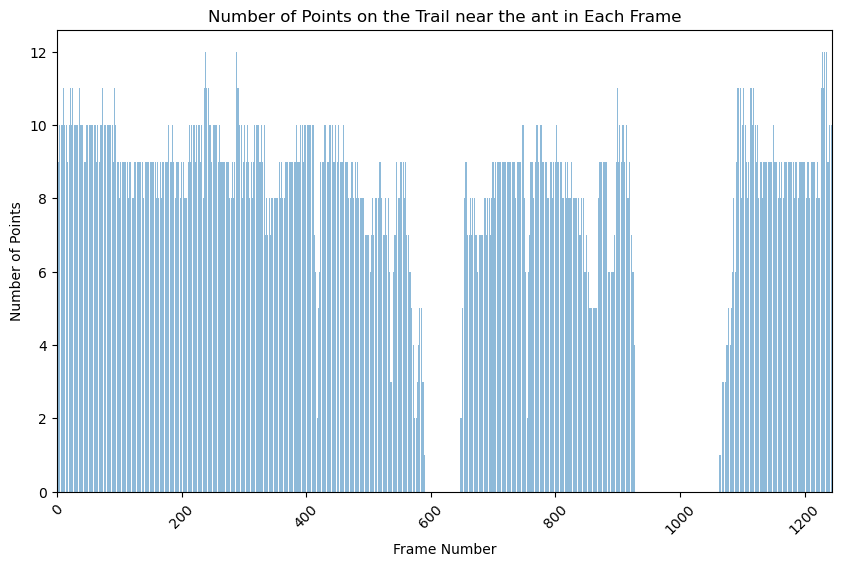

In [118]:
import matplotlib.pyplot as plt

# Reset seaborn and matplotlib to default styles
sns.reset_orig()
plt.rcdefaults()

# Assuming frame_numbers and points_count are already defined
plt.figure(figsize=(10,6))
plt.bar(frames, points_count, alpha=0.5)
plt.xlabel('Frame Number')
plt.ylabel('Number of Points')
plt.title('Number of Points on the Trail near the ant in Each Frame')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability, if needed
plt.xlim(0,len(frames))
plt.show()


1. make a copy of the dataframe.
2. In the new dataframe, focus on the columns "trail_curvature", "tip_deg_L", "fcl_deg_L", "SI_L", "tip_deg_R", "fcl_deg_R", "SI_R".
3. If a datapoint in these columns is 2 standard deviation away, make it a NaN value.
4. Replace the NaN values with the average value of the 2 flanking values, given they are not NaN.
5. In case of 2 or more consecutive NaNs, keep it NaN.

In [128]:
# 1. Make a copy of the dataframe
df_copy = stat_df.copy()

# 2. Focus on the columns 'trail_curvature', tip_deg_L', 'fcl_deg_L', 'SI_L_ang', 'tip_deg_R', 'fcl_deg_R', 'SI_R_ang'
columns_to_focus = ['trail_curvature', 'tip_deg_L', 'fcl_deg_L', 'SI_L_ang', 'tip_deg_R', 'fcl_deg_R', 'SI_R_ang']

# 3. If a datapoint in these columns is 2 standard deviation away, make it a NaN value
for column in columns_to_focus:
    mean = df_copy[column].mean()
    std = df_copy[column].std()
    df_copy.loc[:, column] = df_copy[column].apply(lambda x: np.nan if (x < mean - 2*std) or (x > mean + 2*std) else x)

# 4. Replace the NaN values with the average value of the 2 flanking values, given they are not NaN
# 5. In case of 2 or more consecutive NaNs, keep it NaN - already handled by limit=1 in interpolate

df_copy.interpolate(method='linear', limit=1, limit_direction='both', inplace=True)


# Display the modified dataframe
#df_copy

In [126]:
pd.set_option('display.max_columns', None)
stat_df

frame_quality  trajectory_x  trajectory_y      head_x      head_y  \
0             GOOD    210.823529   1462.556863  139.868713  106.299393   
1             GOOD    214.991597   1465.344538  140.705933  105.163780   
2             GOOD    215.857143   1465.111111  142.684021  101.805054   
3             GOOD    220.651163   1467.550388  141.535248  100.568886   
4             GOOD    228.437247   1468.696356  138.854965   98.329918   
...            ...           ...           ...         ...         ...   
2289           BAD           NaN           NaN    2.694063    2.170939   
2290           BAD           NaN           NaN    2.698844    2.151966   
2291           BAD           NaN           NaN    2.710186    2.174479   
2292           BAD           NaN           NaN    2.696439    2.159683   
2293           BAD           NaN           NaN    2.705877    2.187927   

       gaster_x   gaster_y  bp04_x  bp04_y  bp05_x  bp05_y  bp06_x  bp06_y  \
0     47.563297  90.946609   177.0    62.0   161.0    79.0   151.0    85.0   
1     48.605278  92.953499   138.0    86.0   157.0    74.0   165.0    66.0   
2     51.157211  93.668564   138.0    86.0   155.0    73.0   164.0    65.0   
3     50.549313  94.603020   147.0    76.0   159.0    68.0   165.0    63.0   
4     47.311279  94.327972   145.0    75.0   158.0    68.0   164.0    64.0   
...         ...        ...     ...     ...     ...     ...     ...     ...   
2289   3.247763   2.437172     4.0     0.0    62.0    10.0    82.0    10.0   
2290   3.224337   2.488976     0.0     0.0    48.0     6.0    24.0     2.0   
2291   3.191612   2.498073     1.0     0.0    54.0     9.0    39.0     6.0   
2292   3.210456   2.484827     5.0     0.0    39.0     3.0    78.0     6.0   
2293   3.211549   2.495855    58.0     0.0    33.0     6.0    17.0     9.0   

      bp07_x  bp07_y  bp18_x  bp18_y  bp19_x  bp19_y  bp20_x  bp20_y  bp21_x  \
0      139.0    85.0   145.0   130.0   157.0   138.0   162.0   143.0   165.0   
1      170.0    57.0   147.0   128.0   160.0   134.0   167.0   138.0   172.0   
2      169.0    55.0   153.0   124.0   167.0   130.0   173.0   134.0   179.0   
3      165.0    56.0   153.0   121.0   168.0   126.0   175.0   130.0   181.0   
4      169.0    58.0   151.0   119.0   167.0   123.0   175.0   126.0   181.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
2289   102.0    11.0     4.0     0.0    75.0     4.0    46.0     5.0    17.0   
2290     1.0    10.0     0.0     0.0    20.0     0.0    47.0    10.0    75.0   
2291    25.0     0.0     1.0     0.0    60.0     9.0    59.0     1.0    67.0   
2292   117.0     8.0     5.0     0.0    57.0    11.0    86.0     3.0   116.0   
2293     3.0     2.0    61.0     0.0    30.0     5.0    16.0     8.0     3.0   

      bp21_y  gross_dist     speed near_trail  trail_curvature  \
0      149.0    0.284808  0.000000        YES     1.813521e-19   
1      144.0    0.254386  2.584728        YES    -5.707662e-19   
2      140.0    0.257300  0.462098        YES    -5.707662e-19   
3      137.0    0.234000  2.772635        YES    -5.707662e-19   
4      131.0    0.224339  4.056683        YES    -5.707662e-19   
...      ...         ...       ...        ...              ...   
2289     9.0         NaN       NaN         NO              NaN   
2290     1.0         NaN       NaN         NO              NaN   
2291     1.0         NaN       NaN         NO              NaN   
2292     4.0         NaN       NaN         NO              NaN   
2293     2.0         NaN       NaN         NO              NaN   

      trail_point_Rsq  angle_on_trail  dist_head  dist_gast  ant_trail_ang  \
0                 NaN             NaN     34.547     19.279           9.44   
1                 NaN    7.127014e-15     30.172     18.008           7.55   
2                 NaN    8.154327e-15     27.057     18.793           5.08   
3                 NaN    1.450350e-14     23.697     17.938           3.75   
4                 NaN    7.140024e-

#### Check in what proportion of "GOOD" (from the column "frame_quality") frames the ant is near the trail (if "near_trail" column shows "YES")

In [119]:
# Filter the DataFrame for rows where the "frame_quality" column is "GOOD"
good_frames_df = stat_df[stat_df['frame_quality'] == 'GOOD']

# Calculate the proportion of "GOOD" frames where the ant is near the trail
proportion_near_trail = (good_frames_df['near_trail'] == 'YES').mean()

perc_near_trail = round(proportion_near_trail * 100, 2)
percent_near_trail = f"{perc_near_trail:06.2f}"
percent_near_trail


'086.13'

**Save the stat file as a csv file**

**Save trajectory figure as a png file**

In [120]:

# Append "Final_CSV" to the path_file_folder
path_final_CSV = os.path.join(path_file_folder, "Final_CSV")

# Append "Final_CSV" to the path_file_folder
path_fig_traj = os.path.join(path_file_folder, "Fig_trajectory")

# Ensure the directory exists, if not, create it
os.makedirs(path_final_CSV, exist_ok=True)
os.makedirs(path_fig_traj, exist_ok=True)

ant_filename = path_ant_trajectory.split("/")[-1].rstrip(".csv")
output_filename = ant_filename + "_BodyLengthMean_" + str(body_length_mean) + "_BodyLengthStd_" + str(body_length_std) + "_on_trail_percent_" + str(percent_near_trail)
stat_filename = output_filename + "_statfile" + ".csv"
fig_filename = output_filename + "_trajectory" + ".png"


# Combine the modified directory path with the filename to get the full path
stat_path_filename = os.path.join(path_final_CSV, stat_filename)
fig_path_filename = os.path.join(path_fig_traj, fig_filename)

# Save the dataframe to the specified path
stat_df.to_csv(stat_path_filename, index=False)

print(f"Data saved as: {stat_path_filename}")

# Save the figure to the specified path
fig_trajectory.savefig(fig_path_filename, dpi=300, bbox_inches='tight')

print(f"Figure saved at: {fig_path_filename}")


Data saved as: /Users/souvikmandal/Documents/04_trail_tracking_ants/BU_trail/data_all/20220714/Final_CSV/antmovie220714150105_ant09_trail2_144633_MLT_corr_trailage_0872_BodyLengthMean_93.796_BodyLengthStd_15.869_on_trail_percent_086.13_statfile.csv
Figure saved at: /Users/souvikmandal/Documents/04_trail_tracking_ants/BU_trail/data_all/20220714/Fig_trajectory/antmovie220714150105_ant09_trail2_144633_MLT_corr_trailage_0872_BodyLengthMean_93.796_BodyLengthStd_15.869_on_trail_percent_086.13_trajectory.png


***
**PLEASE USE THE `04a_basic_stat_speed_dist_curve.ipynb` and `04b_advanced_stats_visualization.ipynb` NOTEBOOKS FOR THE NEXT STEP - DATA ANALYSIS.**

**HAPPY DATA ANALYSIS!**
***

**If you want to make a video with the image files created in the previous step, please run the following cell.**

In [125]:

# Define the folder path containing the image files.
# In our case, it is defined before as "new_img_folder".

# Video settings
vid_file_name = stat_filename.rstrip(".csv")
output_file_name = vid_file_name + ".mp4"
fps = 50

# Get the list of image files in the folder
image_files = sorted([f for f in os.listdir(new_img_folder) if f.endswith('.png')])

# Read the first image to get the dimensions
first_image = cv2.imread(os.path.join(new_img_folder, image_files[0]))
height, width, _ = first_image.shape

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec (e.g., XVID, MJPG) for the desired video format
video_writer = cv2.VideoWriter(output_file_name, fourcc, fps, (width, height))

# Write each image to the video
for image_file in image_files:
    image_path = os.path.join(new_img_folder, image_file)
    image = cv2.imread(image_path)
    video_writer.write(image)

# Release the VideoWriter and close the video file
video_writer.release()

print(f"Video saved as {output_file_name}")


Video saved as antmovie220714151709_ant12_trail2_144633_CCW_corr_trailage_1836_BodyLengthMean_91.916_BodyLengthStd_9.422_statfile.mp4
